# 2020-09-18_GrowthImpactOfLandingPads_ODnormalized

## Protocol
    - Diluted 1:100 from overnight, grew for 2 hours
    - Normalized OD to 0.005 in 700 mL M9
        * Fill deep-well plate with 630 uL M9
        * Make 100 uL of 0.05 OD cultures
        * Transfer 70 uL of 0.05 culture to deep-well plate for total of 700 uL @ 0.005
    - Measure OD600 every 1 hour for 4 hours, then every 2 hours until 8 hours

In [1]:
# Matplotlib interactivity
#matplotlib notebook
import matplotlib
matplotlib.rc('figure', dpi = 160)
matplotlib.rcParams['pdf.fonttype'] = 42 # for making font editable when exported to PDF for Illustrator
matplotlib.rcParams['ps.fonttype'] = 42 # for making font editable when exported to PS for Illustrator

# Set the default sans-serif font to Arial"
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Set to always use sans-serif fonts
matplotlib.rcParams['font.family'] = "sans-serif"

In [2]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import sys
import cytoflow as flow
import string
import pandas as pd
import pickle
from scipy.optimize import least_squares
from matplotlib.lines import Line2D
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import scipy
from scipy.optimize import curve_fit


# Dan's custom scripts that aid in importing from conditions.csv file
sys.path.append('/Users/atriassi/Documents/MIT Dropbox (local)/Voigt Lab/_Data/Flow Cytometry Data/cytoflow_example_fromDan/modules')
import cf_imports
import cf_helpers

In [3]:
# Import reloads for when modules are being changed
import importlib
importlib.reload(cf_imports)
importlib.reload(cf_helpers)

<module 'cf_helpers' from '/Users/atriassi/Documents/MIT Dropbox (local)/Voigt Lab/_Data/Flow Cytometry Data/cytoflow_example_fromDan/modules/cf_helpers.py'>

## Data Import

In [4]:
# Renaming the file as "file"
file = '/Users/atriassi/Dropbox (Personal)/Education/Grad School/*Papers/Data_fromSynlogic/10-18-2022  Triassi-Voigt-Synlogic Paper - Growth Curve Data.xlsx'
sheets = ['tidy']

# Another way to get data as dataframe
growth_data = pd.read_excel(file, sheet_name = sheets, header = 0, fill_value = 0)

In [5]:
display(growth_data['tidy'])

,strain_num,time,replicate,od600
0,SYNB1618,0,1,0.095
1,SYNB1618,1,1,0.356
2,SYNB1618,2,1,1.076
3,SYNB1618,3,1,2.380
4,SYNB1618,4,1,3.410
5,SYNB1618,5,1,4.240
6,SYNB1618,6,1,4.240
7,SYNB1618,0,2,0.095
8,SYNB1618,1,2,0.360
9,SYNB1618,2,2,1.063


In [6]:
time = sorted(growth_data['tidy']['time'].unique())

time

[0, 1, 2, 3, 4, 5, 6]

In [7]:
strains = sorted(growth_data['tidy']['strain_num'].unique())

strains

['SYN001', 'SYN7664', 'SYN7696', 'SYN8784', 'SYNB1618', 'SYNB1934']

In [8]:
reps = [1,2,3]

In [9]:
growth_data['tidy'][(growth_data['tidy']['strain_num']=='SYN001') & (growth_data['tidy']['replicate']==1)]

,strain_num,time,replicate,od600
105,SYN001,0,1,0.100
106,SYN001,1,1,0.354
107,SYN001,2,1,2.200
108,SYN001,3,1,4.190
109,SYN001,4,1,4.620
110,SYN001,5,1,4.710
111,SYN001,6,1,5.590


In [10]:
data_dict = dict()

for s in strains:
    data_dict[s] = dict()
    for t in time:
        data_dict[s][t] = dict()
        for r in reps:
                
            q = growth_data['tidy'].query('strain_num == "{}"'.format(s) 
                                           + ' and ' + 'time == {}'.format(t)
                                        + ' and ' + 'replicate == "{}"'.format(r))
#             print(q)

            data_dict[s][t][r] = q['od600'].values[0]
            
#             data_dict[s][t][r] = growth_data['tidy'][(growth_data[sheet]['Strain number'] == s)&(growth_data[sheet]['time']==t)]['od600'].values[0]
        
        
# make dictionary of dataframes beacuse dataframes look nicer
data = dict()

for s in strains:
    data[s] = pd.DataFrame.from_dict(data_dict[s])


In [11]:
data['SYN8784']

,0,1,2,3,4,5,6
1,0.102,0.452,1.299,2.86,3.23,5.34,5.89
2,0.097,0.469,1.303,3.13,3.99,5.80,5.91
3,0.103,0.449,1.304,2.71,4.15,5.68,5.89


In [12]:
# parent = ['EcN']

In [13]:
# dictionary with strain information that can be copied from experiment to experiment
strain_info = dict([('SYNB1618', {'color': 'k', 
                               'parent': 'EcN'}), 
                    ('SYN7664', {'color': 'darkgrey', 
                               'parent': 'EcN'}),
                    ('SYN7696', {'color': '#fbb03b', 
                               'parent': 'EcN'}),
                    ('SYN8784', {'color': '#c20088',
                                'parent': 'EcN'})
                   ])

In [14]:
plot_info = dict()

for r in reps:
#     r = r.astype(str)
    if r == 1:
        plot_info[r] = {'marker': 'o',
                           'facecolor': 'white',
                           'edgecolor': 'black',
                           'linecolor': 'black'}
#                                'edgecolor': 'darkgrey',
#                                'linecolor': 'darkgrey'}
    elif r == 2:
        plot_info[r] =  {'marker': 'o',
                           'facecolor': 'white',
                            'edgecolor': 'darkgrey',
#                                'edgecolor': inducer_info[i]['color'],
                           'linecolor': 'darkgrey'}

    elif r == 3:
        plot_info[r] =  {'marker': 'o',
#                                'facecolor': inducer_info[i]['color'],
                           'facecolor': 'white',
                            'edgecolor': 'lightgrey',
                            'linecolor': 'lightgrey'}
#                                'edgecolor': 'k',
#                                 'linecolor': 'k'}
#                                'linecolor': inducer_info[i]['color']}

In [15]:
plot_info[1]

{'marker': 'o',
 'facecolor': 'white',
 'edgecolor': 'black',
 'linecolor': 'black'}

In [16]:
# list(filtered[filtered['parent_strain']=='AJT207']['strain_num'].unique())[0]

In [17]:
fig_pos = {'SYNB1618': {'fig_row': 0, 'fig_col': 0},
           'SYN7664': {'fig_row': 0, 'fig_col': 1},
           'SYN7696': {'fig_row': 0, 'fig_col': 2},
           'SYN8784': {'fig_row': 0, 'fig_col': 3}}
# fig_pos = dict()

# for i in inducers:
#     fig_pos[i] = {'fig_row': inducers.index(i)//2, 'fig_col': inducers.index(i)-(2*(inducers.index(i)//2))}

fig_pos

{'SYNB1618': {'fig_row': 0, 'fig_col': 0},
 'SYN7664': {'fig_row': 0, 'fig_col': 1},
 'SYN7696': {'fig_row': 0, 'fig_col': 2},
 'SYN8784': {'fig_row': 0, 'fig_col': 3}}

## Plot growth curves (each replicate)

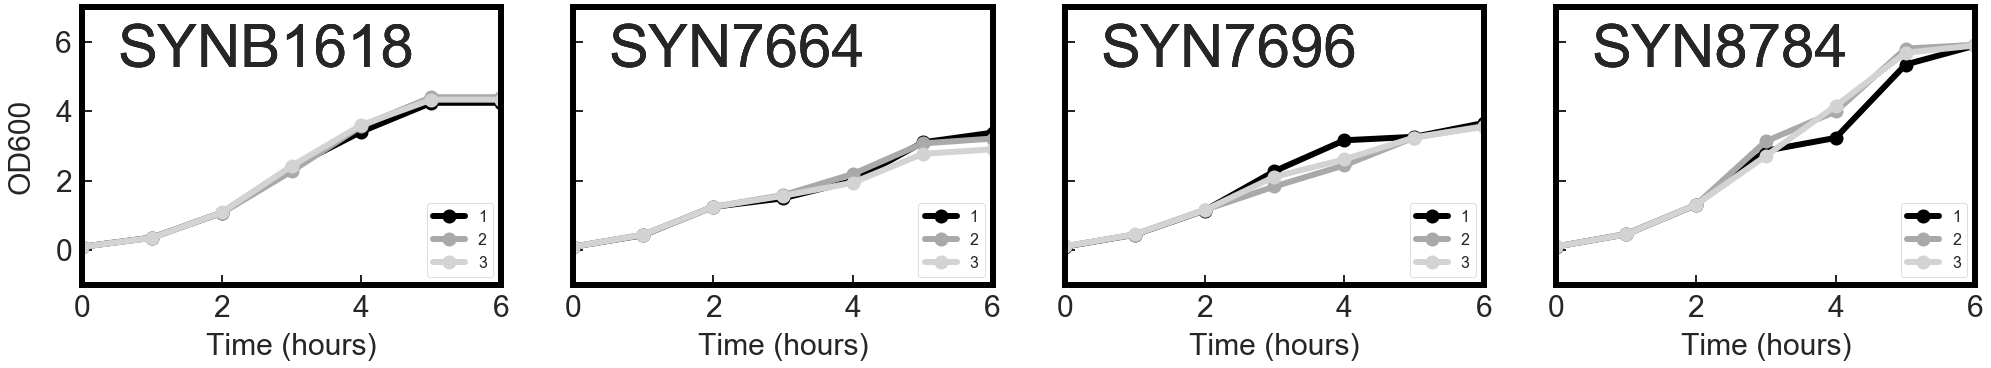

In [18]:
## plot growth curves of each replicate

fig, ax = plt.subplots(1,4, figsize=(30,7.5), sharey = 'row',sharex = 'col') # row, column format
# fig, ax = plt.subplots(4,2, figsize=(15,30), sharey = 'row') # row, column format
plt.tight_layout(pad = 12, h_pad = 10, w_pad = 6) #tidies up spacing between plots

strains_subset = ['SYNB1618','SYN7664','SYN7696','SYN8784']

for s in strains_subset:
    
    FP = ax[fig_pos[s]['fig_col']]
    
    for spine in FP.spines.values():
                        spine.set_edgecolor('black')
                        spine.set_linewidth(6)

    for r in reps:

        ## scatter
        FP.plot(time, data[s].loc[r,:],
                 ms = 12, marker = plot_info[r]['marker'], linestyle = '-', lw = 6,
                    color = plot_info[r]['linecolor'],
                    mec = plot_info[r]['edgecolor'],
                    mfc = plot_info[r]['edgecolor'], mew = 2, 
                    label = r)

        FP.set_yscale('linear')
        FP.set_xscale('linear')

        if fig_pos[s]['fig_col'] == 0:                
            FP.set_ylabel('OD600', size = 30, labelpad = 20)

        FP.set_xlabel('Time (hours)', size = 30, labelpad = 10) 
        
        FP.tick_params(labelsize = 30, length = 10, width = 2, direction = 'in', pad = 10)
        FP.tick_params(which='minor', length = 5, width = 2, direction = 'in')
        FP.set_ylim(-1,7)
        FP.set_xlim(0,6)

        FP.yaxis.grid(False)
        FP.xaxis.grid(False)
        FP.legend(markerscale = 1, fontsize = 16, loc = 'lower right')
    #             ax[fig_pos[s]['fig_row']][fig_pos[s]['fig_col']].legend.legendHandles._legmarker.set_markersize(50)

        FP.text(0.5, 6.5, s, 
                  verticalalignment = 'top', horizontalalignment = 'left', 
                  fontsize = 60)


In [19]:
# fig.savefig('GrowthCurves_EachReplicate.pdf', bbox_inches = "tight", transparent = True)


In [20]:
means = dict()
stdevs = dict()

for s in strains_subset:
    means[s] = data[s].mean(axis=0)
    stdevs[s] = data[s].std(axis=0)

means['SYNB1618']

0    0.095000
1    0.354667
2    1.073667
3    2.356667
4    3.526667
5    4.323333
6    4.323333
dtype: float64

In [21]:
stdevs['SYNB1618']

0    1.699675e-17
1    6.110101e-03
2    9.712535e-03
3    7.767453e-02
4    1.021437e-01
5    8.020806e-02
6    8.020806e-02
dtype: float64

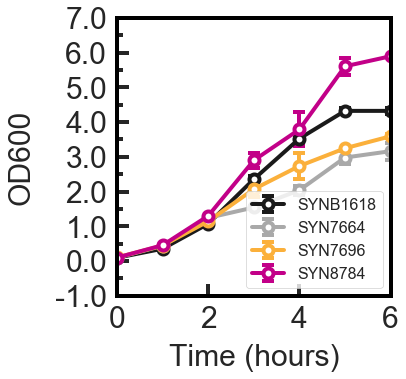

In [22]:
## plot 

fig2, ax2 = plt.subplots(1,1, figsize=(7.5,7.5), sharey = 'row') # row, column format
plt.tight_layout(pad = 12, h_pad = 10, w_pad = 6) #tidies up spacing between plots


FP = ax2 # creating variable so don't have to change ax reference through whole loop

for spine in FP.spines.values():
                    spine.set_edgecolor('black')
                    spine.set_linewidth(4)

for s in strains_subset:

    ## scatter
    FP.errorbar(time, means[s], yerr = stdevs[s],
         ms = 10, marker = 'o', linestyle = '-', lw = 4,
            color = strain_info[s]['color'],
            mec = strain_info[s]['color'],
            mfc = 'white', mew = 4, 
            elinewidth = 4, capsize = 6,
            label = s)

    FP.set_yscale('linear')
    FP.set_xscale('linear')

    FP.set_ylabel('OD600', size = 30, labelpad = 20)

    FP.set_xlabel('Time (hours)', size = 30, labelpad = 10) 

    FP.tick_params(labelsize = 30, length = 12, width = 4, direction = 'in', pad = 10)
    FP.tick_params(which='minor', length = 6, width = 4, direction = 'in')
    FP.set_ylim(-1,7)
    FP.set_xlim(0,6)

    FP.yaxis.set_major_locator(MultipleLocator(1))
    FP.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # %.1f = one decimal point, %.2f = two decimal points
    FP.yaxis.set_minor_locator(MultipleLocator(0.5))

    FP.xaxis.set_major_locator(MultipleLocator(2))
    FP.xaxis.set_major_formatter(FormatStrFormatter('%d'))

    FP.yaxis.grid(False)
    FP.xaxis.grid(False)

    FP.legend(markerscale = 1, fontsize = 16, bbox_to_anchor = (1,0), loc = 'lower right')


# # gets rid of empty plots
# fig.delaxes(ax[1,2]) # zero indexing
# fig.delaxes(ax[2,2]) # zero indexing


In [23]:
# fig2.savefig('GrowthCurves_ErrorBars.pdf', bbox_inches = "tight", transparent = True)


# Modeling growth using logistic and Gompertz equations
Reference: https://aem.asm.org/content/aem/56/6/1875.full.pdf

In [24]:
data

{'SYN001':        0      1     2     3     4     5     6
 1  0.100  0.354  2.20  4.19  4.62  4.71  5.59
 2  0.100  0.350  2.21  4.25  4.71  4.76  5.64
 3  0.099  0.348  2.20  4.22  4.65  4.79  5.58,
 'SYN7664':        0      1      2     3     4     5     6
 1  0.098  0.430  1.243  1.49  1.99  3.10  3.38
 2  0.100  0.444  1.246  1.58  2.19  3.07  3.21
 3  0.098  0.439  1.242  1.56  1.94  2.77  2.90,
 'SYN7696':        0      1      2     3     4     5     6
 1  0.100  0.443  1.138  2.27  3.16  3.26  3.66
 2  0.107  0.444  1.154  1.83  2.44  3.24  3.57
 3  0.108  0.453  1.144  2.11  2.61  3.24  3.55,
 'SYN8784':        0      1      2     3     4     5     6
 1  0.102  0.452  1.299  2.86  3.23  5.34  5.89
 2  0.097  0.469  1.303  3.13  3.99  5.80  5.91
 3  0.103  0.449  1.304  2.71  4.15  5.68  5.89,
 'SYNB1618':        0      1      2     3     4     5     6
 1  0.095  0.356  1.076  2.38  3.41  4.24  4.24
 2  0.095  0.360  1.063  2.27  3.57  4.40  4.40
 3  0.095  0.348  1.082  2.42  3.

In [25]:
t_minutes = [t * 60 for t in time]
print(t_minutes)

[0, 60, 120, 180, 240, 300, 360]


In [26]:
data['SYNB1618'].loc[1,:]

0    0.095
1    0.356
2    1.076
3    2.380
4    3.410
5    4.240
6    4.240
Name: 1, dtype: float64

In [27]:
### different functions to model the growth curve ########################
# t: time, A: max ln(OD), r: specific growth rate, lag: lag time
def func1(t, A, r, lag):
    return A / (1 + np.exp((4 * r * (lag - t)/A) + 2)) # logistic equation

def func2(t, A, r, lag):
    return A * np.exp(-np.exp(r * np.exp(1) * (lag - t)/A + 1)) # Gompertz equation
##########################################################################

OD_min = dict()
OD_log = dict()
results = dict()
pcov = dict()
fit_params = dict()

OD_means_min = dict()
OD_means_log = dict()
results_means = dict()
pcov_means = dict()
fit_params_means = dict()

for s in strains_subset:
    OD_min[s] = dict()
    OD_log[s] = dict()
    results[s] = dict()
    pcov[s] = dict()
    fit_params[s] = dict()
    
    OD_means = means[s]
    OD_means_min[s] = OD_means.min()
    OD_means_log[s] = np.log(OD_means/OD_means_min[s])
    
    # curve fit the test data
    # use max ln(OD) as the initial guess of A
    # initial guess of r (0.02 <= 0.693/expected doubling time) and lag (120) was from inspecting the data
    A_init_means = OD_means_log[s].max()
    initial_guess_means = [A_init_means, 0.02, 120]
        # results, pcov = curve_fit(func1, t, OD_log, initial_guess) # logistic eqn
    results_means[s], pcov_means[s] = curve_fit(func2, t_minutes, OD_means_log[s], initial_guess_means) # Gompertz eqn

    # results is a list containing fitted parameter [A, r, lag] 
    fit_params_means[s] = {'max_OD': results_means[s][0],
                        'growth_rate': results_means[s][1],
                        'lag_time': results_means[s][2],
                        'double_time': np.log(2)/(results_means[s][1]), # results[s][r][1] = growth_rate

                        # get standard error
                        'std_err': np.sqrt(np.diag(pcov_means[s])) # array listing standard error of growth_rate, lag_time, and double_time
                       }    
    
    for r in reps:
        
        # get lowest OD as N_0
        # normalize against N_0 and take natural log
        OD = data[s].loc[r,:]
        OD_min[s][r] = OD.min()
        OD_log[s][r] = np.log(OD/OD_min[s][r])
        
        
        # curve fit the test data
        # use max ln(OD) as the initial guess of A
        # initial guess of r (0.02 <= 0.693/expected doubling time) and lag (120) was from inspecting the data
        A_init = OD_log[s][r].max()
        initial_guess = [A_init, 0.02, 120]
            # results, pcov = curve_fit(func1, t, OD_log, initial_guess) # logistic eqn
        results[s][r], pcov[s][r] = curve_fit(func2, t_minutes, OD_log[s][r], initial_guess) # Gompertz eqn

        # results is a list containing fitted parameter [A, r, lag] 
        fit_params[s][r] = {'max_OD': results[s][r][0],
                            'growth_rate': results[s][r][1],
                            'lag_time': results[s][r][2],
                            'double_time': np.log(2)/(results[s][r][1]), # results[s][r][1] = growth_rate
                            
                            # get standard error
                            'std_err': np.sqrt(np.diag(pcov[s][r])) # array listing standard error of growth_rate, lag_time, and double_time
                           }    

In [28]:
## DOESN'T WORK YET because haven't figured out how to add append to create and append to an array within a dictionary

# params_list = ['max_OD','growth_rate','lag_time','double_time']

# r123_fit_params = dict()

# for s in strains:
#     r123_fit_params[s] = dict()
#     for r in reps:
#         for p in params_list:
#             try:
#                 np.append(r123_fit_params[s][p], fit_params[s][r][p])
#             except KeyError:
#                 r123_fit_params[s][p] = np.array([])
           

In [29]:
fit_params_means['SYNB1618']

{'max_OD': 3.856351217255133,
 'growth_rate': 0.02298097883856428,
 'lag_time': 8.075769933006697,
 'double_time': 30.16177793944869,
 'std_err': array([9.04898415e-02, 1.99876296e-03, 7.34667625e+00])}

In [30]:
fit_params_means['SYN7664']

{'max_OD': 3.3016396336446534,
 'growth_rate': 0.022771752854441506,
 'lag_time': 0.48581374211100775,
 'double_time': 30.438903188111436,
 'std_err': array([1.52388893e-01, 4.73325916e-03, 1.57156978e+01])}

In [31]:
fit_params_means['SYN7696']

{'max_OD': 3.456933357865488,
 'growth_rate': 0.02226871302709151,
 'lag_time': 2.160803869585162,
 'double_time': 31.126503795557532,
 'std_err': array([1.06041035e-01, 2.83549334e-03, 1.01545171e+01])}

In [32]:
fit_params_means['SYN8784']

{'max_OD': 4.03947201874975,
 'growth_rate': 0.02308556238202547,
 'lag_time': 2.370246080295791,
 'double_time': 30.025137316976647,
 'std_err': array([1.43887957e-01, 2.92586703e-03, 1.11128280e+01])}

In [33]:
r123_fit_params

NameError: name 'r123_fit_params' is not defined

In [34]:
fit_params['SYNB1618']

{1: {'max_OD': 3.8285240408427748,
  'growth_rate': 0.023107551354855916,
  'lag_time': 8.110393818632373,
  'double_time': 29.996565621146374,
  'std_err': array([8.81885032e-02, 2.00695515e-03, 7.26179790e+00])},
 2: {'max_OD': 3.880217425995281,
  'growth_rate': 0.022485768380703083,
  'lag_time': 6.814601881569824,
  'double_time': 30.826039334052414,
  'std_err': array([1.02136064e-01, 2.11929439e-03, 8.14837651e+00])},
 3: {'max_OD': 3.860596961501187,
  'growth_rate': 0.023361650013074147,
  'lag_time': 9.317355142432769,
  'double_time': 29.670300692460994,
  'std_err': array([8.29577429e-02, 1.89316900e-03, 6.75397468e+00])}}

## Plotting modeled growth curves on ln(N/N_0) y-axis

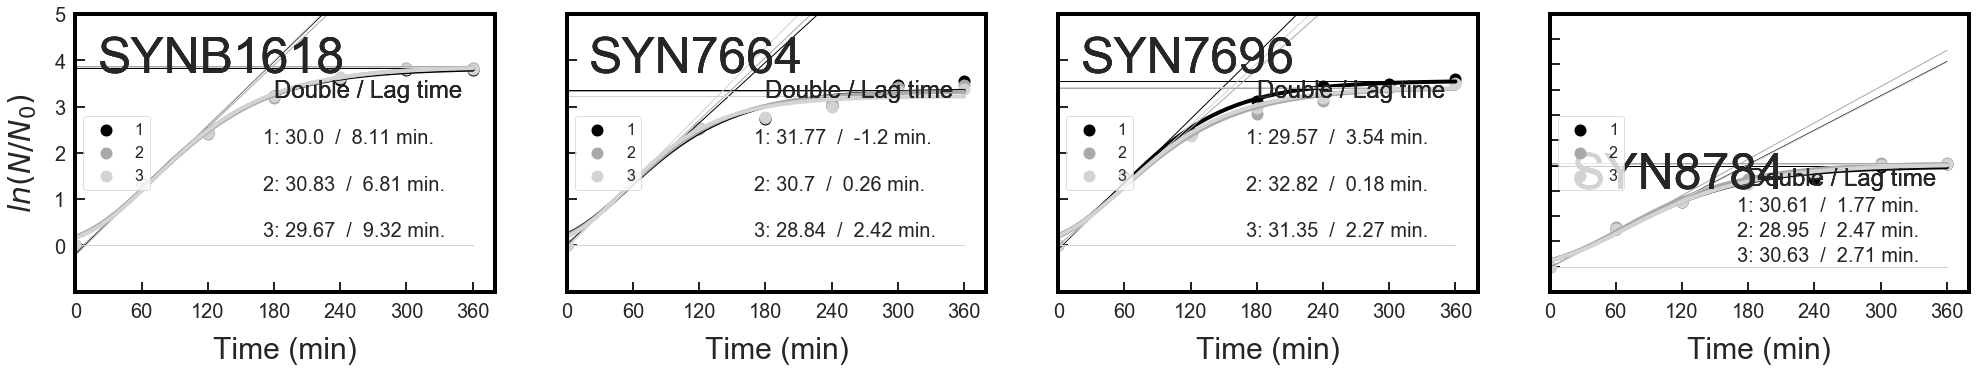

In [35]:
## plot growth curves of each replicate

fig3, ax3 = plt.subplots(1,4, figsize=(30,7.5), sharey = 'row', sharex = 'col') # row, column format
plt.tight_layout(pad = 12, h_pad = 10, w_pad = 6) #tidies up spacing between plots


for s in strains_subset:
    
    FP = ax3[fig_pos[s]['fig_col']]
    
    for spine in FP.spines.values():
                        spine.set_edgecolor('black')
                        spine.set_linewidth(4)

    for r in reps:
        
        ## scatter
        FP.scatter(t_minutes, OD_log[s][r],
                 s = 100, marker = plot_info[r]['marker'], # linestyle = '-', lw = 6,
                    color = plot_info[r]['linecolor'],
                    edgecolor = plot_info[r]['edgecolor'],
                    facecolor = plot_info[r]['edgecolor'], linewidth = 2, 
                    label = r)

        # create data for the fitted equation plot
        x = np.linspace(min(t_minutes), max(t_minutes))
        y = func2(x, *results[s][r]) # for plotting on y-axis of ln(N/N_0)
#         y = np.exp(func2(x, *results[s][r]))*OD_min[s][r] # for plotting on ya
        FP.plot(x, y, color = plot_info[r]['linecolor'], linewidth = 4)

        # draw lowest hightest boundary of ln(N/N_0)
        max_OD = fit_params[s][r]['max_OD']
        
        y_max = 0 * x + max_OD
        y_min = 0 * x
        FP.plot(x, y_max, color = plot_info[r]['linecolor'], linewidth = 1)
        FP.plot(x, y_min, color = plot_info[r]['linecolor'], linewidth = 1)

        # draw the fasted growth rate line
        # this line should pass (lag_time, 0) <= how the constant term came from
        growth_rate = fit_params[s][r]['growth_rate']
        lag_time = fit_params[s][r]['lag_time']
        
        y_maxrate = growth_rate * x - growth_rate * lag_time
        FP.plot(x, y_maxrate, color = plot_info[r]['linecolor'], linewidth = 1)

        # labels and limits
        FP.set_xlabel('Time (min)', size = 30, labelpad = 15)
        if fig_pos[s]['fig_col'] == 0:
            FP.set_ylabel('$ln(N/N_0)$', size = 30, labelpad = 15)
            
        FP.set_ylim(-1, 5)
        FP.set_xlim(0,380)
        
        FP.set_xticks(t_minutes)
        FP.set_yticks(range(11))
        
        FP.tick_params(labelsize = 20, length = 10, width = 2, direction = 'in', pad = 10)
        FP.tick_params(which='minor', length = 5, width = 2, direction = 'in')

        FP.yaxis.grid(False)
        FP.xaxis.grid(False)
        FP.legend(markerscale = 1, fontsize = 16, loc = 'center left')
    #             ax[fig_pos[s]['fig_row']][fig_pos[s]['fig_col']].legend.legendHandles._legmarker.set_markersize(50)

        FP.text(20, 4.5, s, 
                  verticalalignment = 'top', horizontalalignment = 'left', 
                  fontsize = 50)
        
        FP.text(180,3.2,'Double / Lag time',fontsize = 24)
        FP.text(170,2.2 - reps.index(r), 
                '{}: {}  /  {} min.'.format(r, round(fit_params[s][r]['double_time'], 2), 
                                             round(fit_params[s][r]['lag_time'], 2)), fontsize = 20)
        
        

In [36]:
# fig3.savefig('GrowthCurves_timeXlnN-N0__CurveFit_EachReplicate.pdf', bbox_inches = "tight", transparent = True)

KeyError: 'EcN'

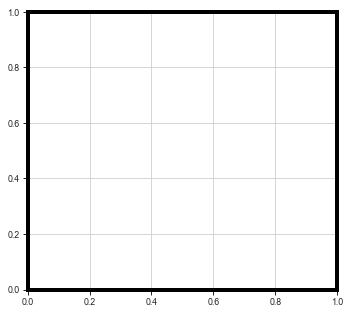

In [37]:
## sample plot to explain how doubling time was calculated

fig_demo, ax_demo = plt.subplots(1,1, figsize=(8,7.5), sharey = 'row', sharex = 'col') # row, column format
plt.tight_layout(pad = 12, h_pad = 10, w_pad = 6) #tidies up spacing between plots
 
FP = ax_demo

for spine in FP.spines.values():
                    spine.set_edgecolor('black')
                    spine.set_linewidth(4)

## scatter
FP.scatter(t_minutes, OD_log['EcN']['r1'],
         s = 100, marker = 'o', # linestyle = '-', lw = 6,
            color = 'black',
            edgecolor = 'black',
            facecolor = 'black', linewidth = 2)

# create data for the fitted equation plot
x = np.linspace(min(t_minutes), max(t_minutes))
y = func2(x, *results['EcN']['r1']) # for plotting on y-axis of ln(N/N_0)
#         y = np.exp(func2(x, *results[s][r]))*OD_min[s][r] # for plotting on ya
FP.plot(x, y, color = 'black', linewidth = 4)

# draw lowest hightest boundary of ln(N/N_0)
max_OD = fit_params[s][r]['max_OD']

y_max = 0 * x + max_OD
y_min = 0 * x
FP.plot(x, y_max, color = 'lightgrey', linewidth = 2)
FP.plot(x, y_min, color = 'lightgrey', linewidth = 2)

# draw the fasted growth rate line
# this line should pass (lag_time, 0) <= how the constant term came from
growth_rate = fit_params['EcN']['r1']['growth_rate']
lag_time = fit_params['EcN']['r1']['lag_time']

y_maxrate = growth_rate * x - growth_rate * lag_time
FP.plot(x, y_maxrate, color = 'lightgrey', linewidth = 2)

# labels and limits
FP.set_xlabel('Time (min)', size = 30, labelpad = 15)
if fig_pos[s]['fig_col'] == 0:
    FP.set_ylabel('$ln(N/N_0)$', size = 30, labelpad = 15)

FP.set_ylim(-1, 8)
FP.set_xlim(0,480)

FP.set_xticks(t_minutes)
FP.set_yticks(range(9))

FP.tick_params(labelsize = 20, length = 10, width = 2, direction = 'in', pad = 10)
FP.tick_params(which='minor', length = 5, width = 2, direction = 'in')

FP.yaxis.grid(False)
FP.xaxis.grid(False)
        
        

In [ ]:
# fig_demo.savefig('GrowthCurve_Demonstration.pdf', bbox_inches = "tight", transparent = True)

## Plotting modeled growth curves on OD600 y-axis

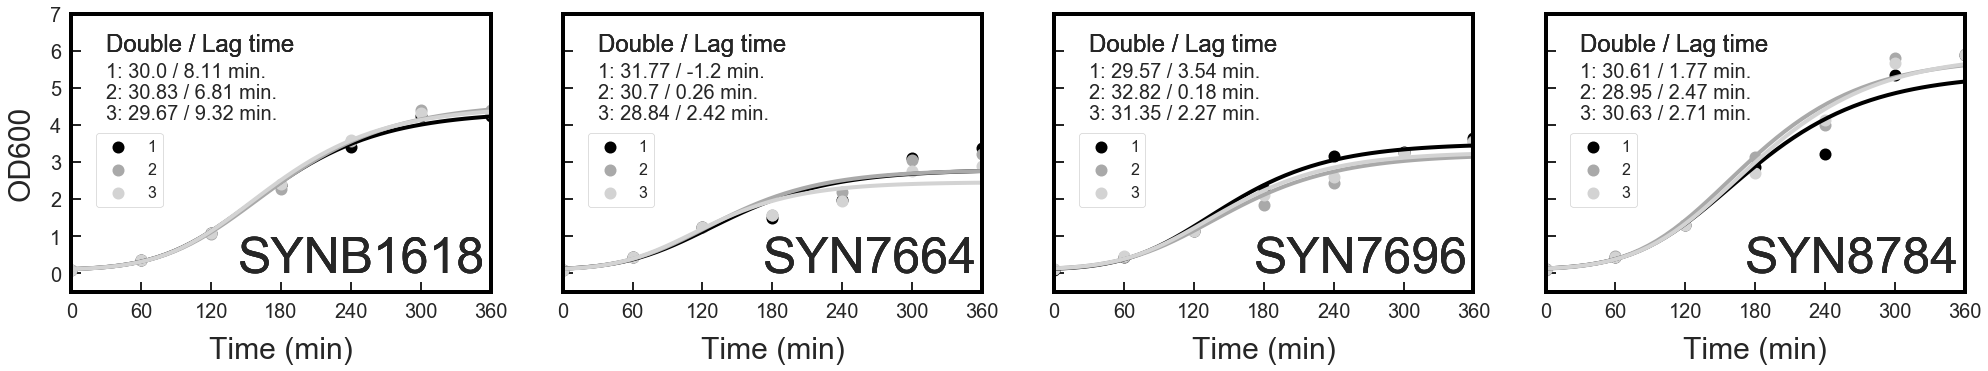

In [38]:
## plot growth curves of each replicate with OD600 as y-axis

fig4, ax4 = plt.subplots(1,4, figsize=(30,7.5), sharey = 'row', sharex = 'col') # row, column format
plt.tight_layout(pad = 12, h_pad = 10, w_pad = 6) #tidies up spacing between plots


for s in strains_subset:
    
    FP = ax4[fig_pos[s]['fig_col']]
    
    for spine in FP.spines.values():
                        spine.set_edgecolor('black')
                        spine.set_linewidth(4)

    for r in reps:
        
        ## scatter
        OD = data[s].loc[r,:]
        
        FP.scatter(t_minutes, OD,
                 s = 100, marker = plot_info[r]['marker'], # linestyle = '-', lw = 6,
                    color = plot_info[r]['linecolor'],
                    edgecolor = plot_info[r]['edgecolor'],
                    facecolor = plot_info[r]['edgecolor'], linewidth = 2, 
                    label = r)

        # create data for the fitted equation plot
        x = np.linspace(min(t_minutes), max(t_minutes))
#         y = func2(x, *results[s][r]) # for plotting on y-axis of ln(N/N_0)
        y = np.exp(func2(x, *results[s][r]))*OD_min[s][r] # for plotting on y-axis of OD600
        FP.plot(x, y, color = plot_info[r]['linecolor'], linewidth = 4)

#         # draw lowest hightest boundary of ln(N/N_0)
#         max_OD = fit_params[s][r]['max_OD']
        
#         y_max = 0 * x + max_OD
#         y_min = 0 * x
#         FP.plot(x, y_max, color = plot_info[r]['linecolor'], linewidth = 1)
#         FP.plot(x, y_min, color = plot_info[r]['linecolor'], linewidth = 1)

#         # draw the fasted growth rate line
#         # this line should pass (lag_time, 0) <= how the constant term came from
#         growth_rate = fit_params[s][r]['growth_rate']
#         lag_time = fit_params[s][r]['lag_time']
        
#         y_maxrate = growth_rate * x - growth_rate * lag_time
#         FP.plot(x, y_maxrate, color = plot_info[r]['linecolor'], linewidth = 1)

        # labels and limits
        FP.set_xlabel('Time (min)', size = 30, labelpad = 15)
        if fig_pos[s]['fig_col'] == 0:
#             FP.set_ylabel('$ln(N/N_0)$', size = 30, labelpad = 15)
            FP.set_ylabel('OD600', size = 30, labelpad = 15)
            
        FP.set_ylim(-0.5, 7)
        FP.set_xlim(0,360)
        
        # ticks
        FP.set_xticks(t_minutes)
        FP.set_yticks(range(8))
        
        FP.tick_params(labelsize = 20, length = 10, width = 2, direction = 'in', pad = 10)
        FP.tick_params(which='minor', length = 5, width = 2, direction = 'in')

        # turn off grid
        FP.yaxis.grid(False)
        FP.xaxis.grid(False)
        
        # legend
        FP.legend(markerscale = 1, fontsize = 16, bbox_to_anchor=(0.04,0.6), loc = 'upper left')
    #             ax[fig_pos[s]['fig_row']][fig_pos[s]['fig_col']].legend.legendHandles._legmarker.set_markersize(50)

        # text labels
        FP.text(355, -0.25, s, 
                  verticalalignment = 'bottom', horizontalalignment = 'right', 
                  fontsize = 50)
        
        FP.text(30,6,'Double / Lag time',fontsize = 24)
        FP.text(30,5.3 - reps.index(r)/1.75, 
                '{}: {} / {} min.'.format(r, round(fit_params[s][r]['double_time'], 2), 
                                             round(fit_params[s][r]['lag_time'], 2)), fontsize = 20)
        
        

In [ ]:
# fig4.savefig('GrowthCurves_timeXod600_CurveFit_EachReplicate.pdf', bbox_inches = "tight", transparent = True)

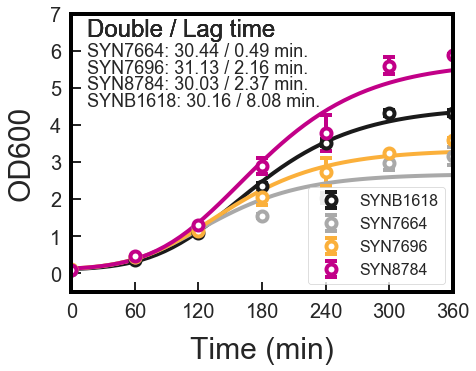

In [39]:
## plot growth curves of means with OD600 as y-axis

fig5, ax5 = plt.subplots(1,1, figsize=(9,7.5)) # row, column format
plt.tight_layout(pad = 12, h_pad = 10, w_pad = 6) #tidies up spacing between plots


for s in strains_subset:
    
    FP = ax5
    
    for spine in FP.spines.values():
                        spine.set_edgecolor('black')
                        spine.set_linewidth(4)
        
    ## scatter
    OD = means[s]

    FP.errorbar(t_minutes, OD,
                yerr = stdevs[s],
                ms = 10, marker = 'o', linestyle = 'none',
                color = strain_info[s]['color'],
                mec = strain_info[s]['color'],
                mfc = 'white', mew = 4, 
                elinewidth = 4, capsize = 6,
                label = s)

    # create data for the fitted equation plot
    x = np.linspace(min(t_minutes), max(t_minutes))
#         y = func2(x, *results[s][r]) # for plotting on y-axis of ln(N/N_0)
    y = np.exp(func2(x, *results_means[s]))*OD_means_min[s] # for plotting on y-axis of OD600
    FP.plot(x, y, color = strain_info[s]['color'], linewidth = 4)

#         # draw lowest hightest boundary of ln(N/N_0)
#         max_OD = fit_params[s][r]['max_OD']

#         y_max = 0 * x + max_OD
#         y_min = 0 * x
#         FP.plot(x, y_max, color = plot_info[r]['linecolor'], linewidth = 1)
#         FP.plot(x, y_min, color = plot_info[r]['linecolor'], linewidth = 1)

#         # draw the fasted growth rate line
#         # this line should pass (lag_time, 0) <= how the constant term came from
#         growth_rate = fit_params[s][r]['growth_rate']
#         lag_time = fit_params[s][r]['lag_time']

#         y_maxrate = growth_rate * x - growth_rate * lag_time
#         FP.plot(x, y_maxrate, color = plot_info[r]['linecolor'], linewidth = 1)

    # labels and limits
    FP.set_xlabel('Time (min)', size = 30, labelpad = 15)
    if fig_pos[s]['fig_col'] == 0:
#             FP.set_ylabel('$ln(N/N_0)$', size = 30, labelpad = 15)
        FP.set_ylabel('OD600', size = 30, labelpad = 15)

    FP.set_ylim(-0.5, 7)
    FP.set_xlim(0,360)

    # ticks
    FP.set_xticks(t_minutes)
    FP.set_yticks(range(8))

    FP.tick_params(labelsize = 20, length = 10, width = 2, direction = 'in', pad = 10)
    FP.tick_params(which='minor', length = 5, width = 2, direction = 'in')

    # turn off grid
    FP.yaxis.grid(False)
    FP.xaxis.grid(False)

    # legend
    FP.legend(markerscale = 1, fontsize = 16, loc = 'lower right')# bbox_to_anchor=(0.04,0.45), loc = 'upper left')
#             ax[fig_pos[s]['fig_row']][fig_pos[s]['fig_col']].legend.legendHandles._legmarker.set_markersize(50)

#     # text labels
#     FP.text(475, -0.25, s, 
#               verticalalignment = 'bottom', horizontalalignment = 'right', 
#               fontsize = 50)

    FP.text(15,6.4,'Double / Lag time',fontsize = 24)
    FP.text(15,6.3 - strains.index(s)/2.25, 
            '{}: {} / {} min.'.format(s, round(fit_params_means[s]['double_time'], 2), 
                                         round(fit_params_means[s]['lag_time'], 2)), fontsize = 18)

        

In [ ]:
# fig5.savefig('GrowthCurves_timeXod600_CurveFit_ErrorBars.pdf', bbox_inches = "tight", transparent = True)

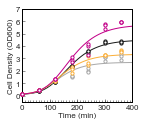

In [41]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

## plot growth curves of means with OD600 as y-axis

fig5_pub, ax5_pub = plt.subplots(1,1, figsize=(2,1.6)) # row, column format
plt.tight_layout(pad = 0) #tidies up spacing between plots


for s in strains_subset:
    
    FP = ax5_pub
    
    for spine in FP.spines.values():
                        spine.set_edgecolor('black')
                        spine.set_linewidth(1)
    
    for r in reps:

        ## scatter
        OD = data[s].loc[r,:]

        FP.scatter(t_minutes, OD,
                    s = 10, marker = 'o', # linestyle = '-', lw = 6,
                    color = strain_info[s]['color'],
                    edgecolor = strain_info[s]['color'],
                    facecolor = 'white', linewidth = 1, clip_on=False, zorder=11)

    ## scatter
#     OD = means[s]

#     FP.errorbar(t_minutes, OD,
#                 yerr = stdevs[s],
#                 ms = 4, marker = 'o', linestyle = 'none',
#                 color = strain_info[s]['color'],
#                 mec = strain_info[s]['color'],
#                 mfc = 'white', mew = 1, 
#                 elinewidth = 1, capsize = 2.25, capthick = 1)

    

    # create data for the fitted equation plot
    x = np.linspace(min(t_minutes), 500)
#         y = func2(x, *results[s][r]) # for plotting on y-axis of ln(N/N_0)
    y = np.exp(func2(x, *results_means[s]))*OD_means_min[s] # for plotting on y-axis of OD600
    FP.plot(x, y, color = strain_info[s]['color'], linewidth = 1, label = s)

#         # draw lowest hightest boundary of ln(N/N_0)
#         max_OD = fit_params[s][r]['max_OD']

#         y_max = 0 * x + max_OD
#         y_min = 0 * x
#         FP.plot(x, y_max, color = plot_info[r]['linecolor'], linewidth = 1)
#         FP.plot(x, y_min, color = plot_info[r]['linecolor'], linewidth = 1)

#         # draw the fasted growth rate line
#         # this line should pass (lag_time, 0) <= how the constant term came from
#         growth_rate = fit_params[s][r]['growth_rate']
#         lag_time = fit_params[s][r]['lag_time']

#         y_maxrate = growth_rate * x - growth_rate * lag_time
#         FP.plot(x, y_maxrate, color = plot_info[r]['linecolor'], linewidth = 1)

    # labels and limits
    FP.set_xlabel('Time (min)', size = 8, labelpad = 2)
    if fig_pos[s]['fig_col'] == 0:
#             FP.set_ylabel('$ln(N/N_0)$', size = 30, labelpad = 15)
        FP.set_ylabel('Cell Density (OD600)', size = 8, labelpad = 2)

    FP.set_ylim(-0.5, 7)
    FP.set_xlim(0,400)

    # ticks
    x_major = matplotlib.ticker.MultipleLocator(base = 100)
    FP.xaxis.set_major_locator(x_major)
    
    x_minor = matplotlib.ticker.MultipleLocator(base = 10)
    FP.xaxis.set_minor_locator(x_minor)
    
    FP.set_yticks(range(8))

    FP.tick_params(labelsize = 8, length = 3, width = 0.5, direction = 'in', pad = 2)
    FP.tick_params(which='minor', length = 2, width = 0.5, direction = 'in')

    # turn off grid
    FP.yaxis.grid(False)
    FP.xaxis.grid(False)

    # legend
#     FP.legend(markerscale = 1, fontsize = 8, loc = 'lower right')# bbox_to_anchor=(0.04,0.45), loc = 'upper left')
#             ax[fig_pos[s]['fig_row']][fig_pos[s]['fig_col']].legend.legendHandles._legmarker.set_markersize(50)



        

In [42]:
# fig5_pub.savefig('GrowthCurves_timeXod600_CurveFit_ErrorBars.pdf', bbox_inches = "tight", transparent = True)
fig5_pub.savefig('Fig4C_GrowthCurves_timeXod600_CurveFit_AllPoints.pdf', bbox_inches = "tight", transparent = True)